### Edgar Moises Hernandez-Gonzalez
#### 09/04/20-11/04/20
#### Clasificacion de imagenes motoras en EEG con Fine Tuning
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical

##### VGG16
##### Sujeto 1
##### Accuracy = 44.10%
##### Kappa = 0.2546

##### InceptionV3
##### Sujeto 1
##### Accuracy = 45.49%
##### Kappa = 0.2731

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [7]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [8]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [9]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (299, 299) #ancho, alto
  datos = np.zeros((288,299,299,3))
  temporal = np.zeros((2816,1000,3))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      x = abs(coef)
      temporal[j*128:(j+1)*128, :, 0] = x
      temporal[j*128:(j+1)*128, :, 1] = x
      temporal[j*128:(j+1)*128, :, 2] = x
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

In [0]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

In [13]:
print(x_train.shape)
print(x_test.shape)

(288, 299, 299, 3)
(288, 299, 299, 3)


In [14]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

66.0605704209217
58.92652956329641
0.002633029815965031
0.0028018946790724928
3.8612014821606695
3.7636597542096775


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 67.0
x_test /= 67.0

In [16]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.98597866
0.87950045
3.9298953e-05
4.1819323e-05
0.05762994
0.056173973


In [0]:
base_model = InceptionV3(weights='imagenet',
                   include_top=False,
                   input_shape=x_train.shape[1:])

In [0]:
# operación global de agrupación máxima para datos espaciales.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# entrenar solo las capas superiores (top) que se inicializaron aleatoriamente
# congelar todas las capas convolucionales de InceptionV3
for layer in base_model.layers:
    layer.trainable = False

In [0]:
# debe hacerse después de configurar las capas como no entrenables
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Iteration: 1
Epoch 1/40
16/16 - 3s - loss: 1.5856 - accuracy: 0.2778 - val_loss: 1.3266 - val_accuracy: 0.3681
Epoch 2/40
16/16 - 2s - loss: 1.3790 - accuracy: 0.3264 - val_loss: 1.3589 - val_accuracy: 0.2639
Epoch 3/40
16/16 - 2s - loss: 1.3719 - accuracy: 0.3229 - val_loss: 1.2880 - val_accuracy: 0.3958
Epoch 4/40
16/16 - 2s - loss: 1.3397 - accuracy: 0.3333 - val_loss: 1.2668 - val_accuracy: 0.3403
Epoch 5/40
16/16 - 2s - loss: 1.3059 - accuracy: 0.3368 - val_loss: 1.5209 - val_accuracy: 0.2604
Epoch 6/40
16/16 - 2s - loss: 1.2873 - accuracy: 0.3681 - val_loss: 1.2889 - val_accuracy: 0.3646
Epoch 7/40
16/16 - 2s - loss: 1.2979 - accuracy: 0.4097 - val_loss: 1.2392 - val_accuracy: 0.4097
Epoch 8/40
16/16 - 2s - loss: 1.2670 - accuracy: 0.3819 - val_loss: 1.2391 - val_accuracy: 0.3958
Epoch 9/40
16/16 - 2s - loss: 1.2693 - accuracy: 0.3819 - val_loss: 1.2649 - val_accuracy: 0.3194
Epoch 10/40
16/16 - 2s - loss: 1.2308 - accuracy: 0.3854 - val_loss: 1.2500 - val_accuracy: 0.4028
Epoch 

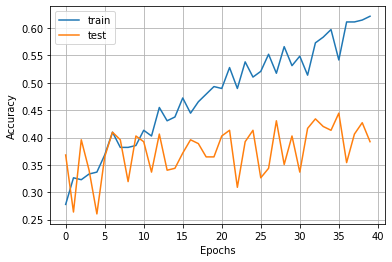

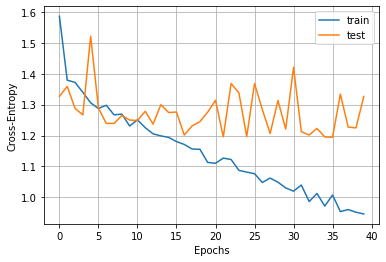


Resultados:
loss: [1.3263412714004517]
accuracy: [0.3923611044883728]
kappa: [0.18981481481481477]


In [26]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(1):
  print("Iteration:", i+1)

  history = model.fit(x_train, y_train, epochs=40, batch_size=18,
                      validation_data=(x_test, y_test), verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [27]:
# en este punto las capas superiores (top) estan entrenadas
# podemos empezar a ajustar el fine tuning
# congelaremos n capas inferiores (bottom)
# entrenar las capas superiores (top) restantes
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [0]:
# entrenar los 2 bloques de inicio principales
# congelaremos las primeras 249 capas y descongelaremos el resto
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [0]:
# recompilar el modelo
model.compile(optimizer = SGD(lr=1e-6, momentum=0.9), #lr=0.0001, momentum=0.9
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Iteration: 1
Epoch 1/400
16/16 - 3s - loss: 9.3999 - accuracy: 0.2500 - val_loss: 1.3512 - val_accuracy: 0.3819
Epoch 2/400
16/16 - 2s - loss: 9.2831 - accuracy: 0.2500 - val_loss: 1.4999 - val_accuracy: 0.3507
Epoch 3/400
16/16 - 2s - loss: 9.0976 - accuracy: 0.2500 - val_loss: 1.6773 - val_accuracy: 0.3472
Epoch 4/400
16/16 - 2s - loss: 8.9481 - accuracy: 0.2500 - val_loss: 1.8318 - val_accuracy: 0.3264
Epoch 5/400
16/16 - 2s - loss: 8.7805 - accuracy: 0.2500 - val_loss: 1.9991 - val_accuracy: 0.3021
Epoch 6/400
16/16 - 2s - loss: 8.6490 - accuracy: 0.2500 - val_loss: 2.1985 - val_accuracy: 0.2812
Epoch 7/400
16/16 - 2s - loss: 8.4901 - accuracy: 0.2500 - val_loss: 2.4268 - val_accuracy: 0.2639
Epoch 8/400
16/16 - 2s - loss: 8.3268 - accuracy: 0.2500 - val_loss: 2.6644 - val_accuracy: 0.2569
Epoch 9/400
16/16 - 2s - loss: 8.1609 - accuracy: 0.2500 - val_loss: 2.8921 - val_accuracy: 0.2500
Epoch 10/400
16/16 - 2s - loss: 8.0198 - accuracy: 0.2500 - val_loss: 3.1097 - val_accuracy: 0.2

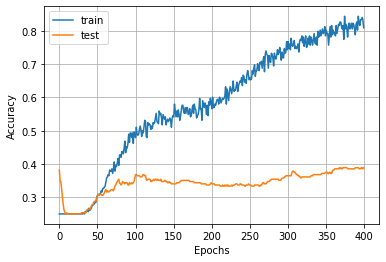

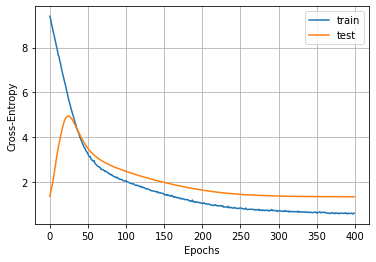


Resultados:
loss: [1.330949306488037]
accuracy: [0.3888888955116272]
kappa: [0.18518518518518523]


In [30]:
# entrenamos nuestro modelo nuevamente
# fine tuning a 2 bloques (top) superiores de inception
# y a las capas superiores (top)
array_loss = []
array_acc = []
array_kappa = []
for i in range(1):
  print("Iteration:", i+1)

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [32]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.3889
std: (+/- 0.0000)
Mean Kappa: 0.1852
std: (+/- 0.0000)
Max Accuracy: 0.3889
Max Kappa: 0.1852
